In [2]:
#Встановлюємо необхідні дані
!pip install pyspark==3.0.1 py4j==0.10.9

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 204.2/204.2 MB 2.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 198.6/198.6 kB 11.0 MB/s eta 0:00:00
  Created wheel for pyspark: filename=pyspark-3.0.1-py2.py3-none-any.whl size=204612223 sha256=f9c0bb5307751b898d0675d4d758bef36509350550ae53f5e3e50ac474eb275d
  Stored in directory: /root/.cache/pip/wheels/19/b0/c8/6cb894117070e130fc44352c2a13f15b6c27e440d04a84fb48
Successfully built pyspark
  Attempting uninstall: py4j
    Found existing installation: py4j 0.10.9.7
    Uninstalling py4j-0.10.9.7:
      Successfully uninstalled py4j-0.10.9.7


In [3]:
#Імпортуємо pyspark
from pyspark.sql import SparkSession

spark = SparkSession.builder\
        .master("local[*]")\
        .appName('PySpark_Tutorial')\
        .getOrCreate()

In [5]:
#Виводимо схему даних за допомогою PrintSchema
data = spark.read.csv(
    'bestsellers with categories.csv',
    sep=',',
    header=True,
)

data.printSchema()

root
 |-- Name: string (nullable = true)
 |-- Author: string (nullable = true)
 |-- User Rating: string (nullable = true)
 |-- Reviews: string (nullable = true)
 |-- Price: string (nullable = true)
 |-- Year: string (nullable = true)
 |-- Genre: string (nullable = true)



In [7]:
author_with_highest_rating = data.orderBy(data['User Rating'].desc()).select('Author').first()[0]

# Виведення автора з найвищим рейтингом
print("Автор з найвищим рейтингом:", author_with_highest_rating)

Автор з найвищим рейтингом: Bill Martin Jr.


In [9]:
author_with_lowest_rating = data.orderBy(data['User Rating']).select('Author').first()[0]

# Виведення автора з найнижчим рейтингом
print("Автор з найнижчим рейтингом:", author_with_lowest_rating)

Автор з найнижчим рейтингом: J.K. Rowling


In [14]:
#Виводимо назви стовпців і типи даних за допомогою dtypes
import pandas as pd

# Конвертація DataFrame у pandas DataFrame
pandas_df = data.toPandas()

# Виведення назв стовпців і типів даних
print(pandas_df.dtypes)

Name           object
Author         object
User Rating    object
Reviews        object
Price          object
Year           object
Genre          object
dtype: object


In [15]:
#Виводимо перші п'ять рядків (використовується метод head)
data.head(5)

[Row(Name='10-Day Green Smoothie Cleanse', Author='JJ Smith', User Rating='4.7', Reviews='17350', Price='8', Year='2016', Genre='Non Fiction'),
 Row(Name='11/22/63: A Novel', Author='Stephen King', User Rating='4.6', Reviews='2052', Price='22', Year='2011', Genre='Fiction'),
 Row(Name='12 Rules for Life: An Antidote to Chaos', Author='Jordan B. Peterson', User Rating='4.7', Reviews='18979', Price='15', Year='2018', Genre='Non Fiction'),
 Row(Name='1984 (Signet Classics)', Author='George Orwell', User Rating='4.7', Reviews='21424', Price='6', Year='2017', Genre='Fiction'),
 Row(Name='5,000 Awesome Facts (About Everything!) (National Geographic Kids)', Author='National Geographic Kids', User Rating='4.8', Reviews='7665', Price='12', Year='2019', Genre='Non Fiction')]

In [16]:
#Виводимо перший рядок за допомогою first()
first_row = data.first()
print(first_row)

Row(Name='10-Day Green Smoothie Cleanse', Author='JJ Smith', User Rating='4.7', Reviews='17350', Price='8', Year='2016', Genre='Non Fiction')


In [17]:
#Робимо опис датасету за допомогою describe()
data.describe().show()

+-------+--------------------+----------------+-------------------+------------------+------------------+------------------+-----------+
|summary|                Name|          Author|        User Rating|           Reviews|             Price|              Year|      Genre|
+-------+--------------------+----------------+-------------------+------------------+------------------+------------------+-----------+
|  count|                 550|             550|                550|               550|               550|               550|        550|
|   mean|                null|            null|  4.618363636363641|11953.281818181818|              13.1|            2014.0|       null|
| stddev|                null|            null|0.22698036502519656|11731.132017431892|10.842261978422364|3.1651563841692782|       null|
|    min|"The Plant Parado...|Abraham Verghese|                3.3|             10009|                 0|              2009|    Fiction|
|    max|You Are a Badass:...|    Zhi Gan

In [18]:
#Виводимо список стовпців за допомогою columns()
print(data.columns)

['Name', 'Author', 'User Rating', 'Reviews', 'Price', 'Year', 'Genre']


In [19]:
#Виводимо загальну кількість рядків даних за допомогою count()
data.count()

550

In [20]:
data = data.na.drop()

# Заміна типів даних на числовий
from pyspark.sql.types import FloatType

# Функція для перетворення типів даних на числовий
def to_numeric(col):
    return col.cast(FloatType())

# Перетворення типів даних для кожного стовпця
for column in data.columns:
    data = data.withColumn(column, to_numeric(data[column]))

# Вивід схеми даних після заміни типів
data.printSchema()

root
 |-- Name: float (nullable = true)
 |-- Author: float (nullable = true)
 |-- User Rating: float (nullable = true)
 |-- Reviews: float (nullable = true)
 |-- Price: float (nullable = true)
 |-- Year: float (nullable = true)
 |-- Genre: float (nullable = true)



In [21]:
from pyspark.sql.functions import mean

# Обчислення середніх значень за стовпцем
mean_values = data.agg(*(mean(column).alias(column) for column in data.columns)).first().asDict()

# Заміна пропущених значень на середні за стовпцем
for column in data.columns:
    data = data.withColumn(column, F.when(data[column].isNull(), mean_values[column]).otherwise(data[column]))

# Перетворення типів даних на числовий
for column in data.columns:
    data = data.withColumn(column, data[column].cast('float'))

# Вивід схеми даних після заміни типів
data.printSchema()

NameError: name 'F' is not defined

In [22]:
#Про скільки книг зберігає дані датасет?
total_books = data.count()
print("Загальна кількість книг у датасеті:", total_books)

Загальна кількість книг у датасеті: 550


In [23]:
#Зміна назви всіх колонок
new_columns = ['name', 'author', 'user_rating', 'reviews', 'price', 'year', 'genre']
data = data.toDF(*new_columns)

In [25]:
author_reviews_sum = data.groupBy('author').agg(F.sum('reviews').alias('total_reviews'))

#Сортування дані за спаданням суми рецензій
author_with_most_reviews = author_reviews_sum.orderBy(author_reviews_sum['total_reviews'].desc()).select('author').first()[0]

#Виведення автора з найбільшою кількістю рецензій
print("Автор з найбільшою кількістю рецензій:", author_with_most_reviews)

NameError: name 'F' is not defined

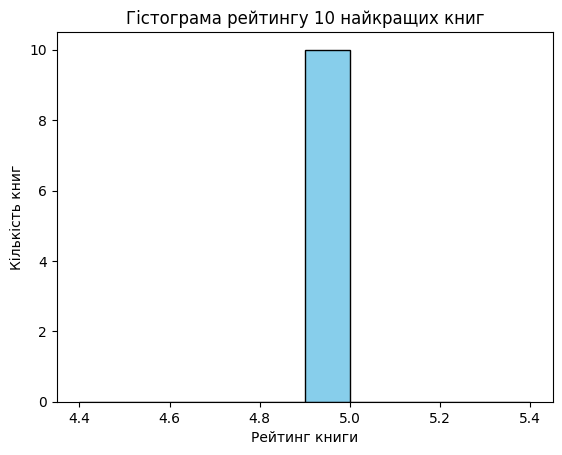

In [26]:
#Відбір книги з найвищим рейтингом
top_books = data.orderBy(data['user_rating'].desc()).limit(10)

#Конвертація DataFrame у Pandas DataFrame для побудови гістограми
top_books_df = top_books.toPandas()

#Побудова гістограми
plt.hist(top_books_df['user_rating'], bins=10, color='skyblue', edgecolor='black')
plt.xlabel('Рейтинг книги')
plt.ylabel('Кількість книг')
plt.title('Гістограма рейтингу 10 найкращих книг')
plt.show()

In [27]:
selected_columns = ['user_rating', 'reviews', 'price']
selected_data = data.select(selected_columns)

#Конвертація DataFrame у Pandas DataFrame
selected_df = selected_data.toPandas()

#Побудова матриці кореляції
correlation_matrix = selected_df.corr()

#Виведення матриці кореляції
print(correlation_matrix)

             user_rating   reviews     price
user_rating     1.000000 -0.001729 -0.133086
reviews        -0.001729  1.000000 -0.109182
price          -0.133086 -0.109182  1.000000


Отже, у висновку ця лабораторна робота допомагає ліпше зрозуміти дані, що вона містить, та вивчити основні методи роботи з ними, такі як очистка даних, аналіз та візуалізація. Результати аналізу можуть бути корисними для прийняття рішень у сфері видавничої та книготоргівельної діяльності.